Dans ce notebook, je propose de tester un détecteur d'anomalies à partir d'un AutoEncoder sur pytorch.

La détection d'anomalies (en anglais, anomaly detection ou outlier detection) est l'identification d'éléments, d'événements ou d'observations rares qui soulèvent des suspicions en différant de manière significative de la majorité des autres données. https://fr.wikipedia.org/wiki/D%C3%A9tection_d%27anomalies.

Supposons qu'on gère une chambre froide. On décide d'y installer un capteur qui nous donne la température toutes les cinq minutes. Ce détecteur d'anomalie pourra par exemple alerter en cas d'hausse brutale (ou de baisse) de la température.

Les données peuvent être retrouvées directement sur https://www.kaggle.com/boltzmannbrain/nab ou https://github.com/numenta/NAB.




Le travail se déroule comme suit:
* Chargement et préparation de nos données
* Définition de notre autoencoder et Entrainement 
* Test sur des données avec anomalie

## Chargement et préparation des données

In [1]:
import pandas as pd 
import numpy as np


import matplotlib.pyplot as plt


from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
torch.manual_seed(42)

import seaborn as sns; sns.set()

sns.set_style('whitegrid')


Je définis une fonction qui charge et trace automatiquement les données.

Les données sont artificielles, un enregistrement toutes les cinq minutes pendant 14 jours.

J'utilise:
* art_daily_small_noise.csv pour l'entrainement de mon AutoEncodeur: données **sans anomalie**
* art_daily_jumpsdown.csv et art_daily_jumpsup.csv pour le test: données qui comportent une **anomalie**


In [2]:
def get_data(url='art_daily_small_noise.csv'):
    '''
    inputs:
    -------
    url (string): path to file
    
    returns:
    --------
    
    df: pandas dataframe
    
    '''
    df=pd.read_csv(url, index_col='timestamp',parse_dates=True)
    df.plot(legend=False)
    plt.title(url.split('.')[0])
    return df
    
    
    

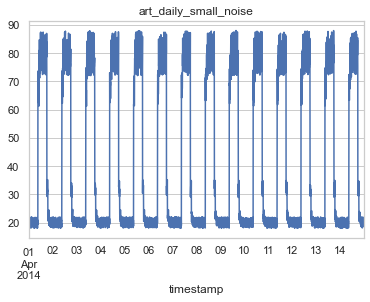

In [3]:
df_noise=get_data()


In [4]:
#pas de temps (longeur du signal)==288 qui correspond aux données pour chaque jour
length_Seq=int(df_noise.groupby(df_noise.index.day).count().loc[1].values)
print("Longueur d'une séquence:", length_Seq)

Longueur d'une séquence: 288


In [5]:
mean=np.mean(df_noise.values) #On garde ces valeurs pour la normalisation sur les données test
std=np.std(df_noise.values)

def normalize(valeur):
    
    return (np.array(valeur)-mean)/std

In [6]:
df_noise=normalize(df_noise)

Pour pouvoir être entrainé par notre autoencodeur, nous avons besoin de générer de nos données des séquences de longeur ***length_Seq***=288. 



Cette  fonction ci_dessus sert à cela.

In [7]:

def create_S(values, length_Seq=length_Seq):
    '''
    inputs:
    ------
    values: list or np array 
    length_Seq:window or timestep
    
    return:
    -------
    r: np array
         shape: (len(values)-length_Seq ,1 ,length_Seq)
    
    
    '''
    output=[]
    for i in range(len(values)-length_Seq):
        output.append(values[i:(i+length_Seq)].reshape(1,-1))
    return np.stack(output)    
        

In [8]:
seq=create_S(df_noise, length_Seq)
seq=torch.tensor(seq) #On convertit en tensor

In [9]:
seq.size() #La taille de notre séquence, 3744 de séquences d'array de tailles 288

torch.Size([3744, 1, 288])

### Construction de notre AutoEncodeur

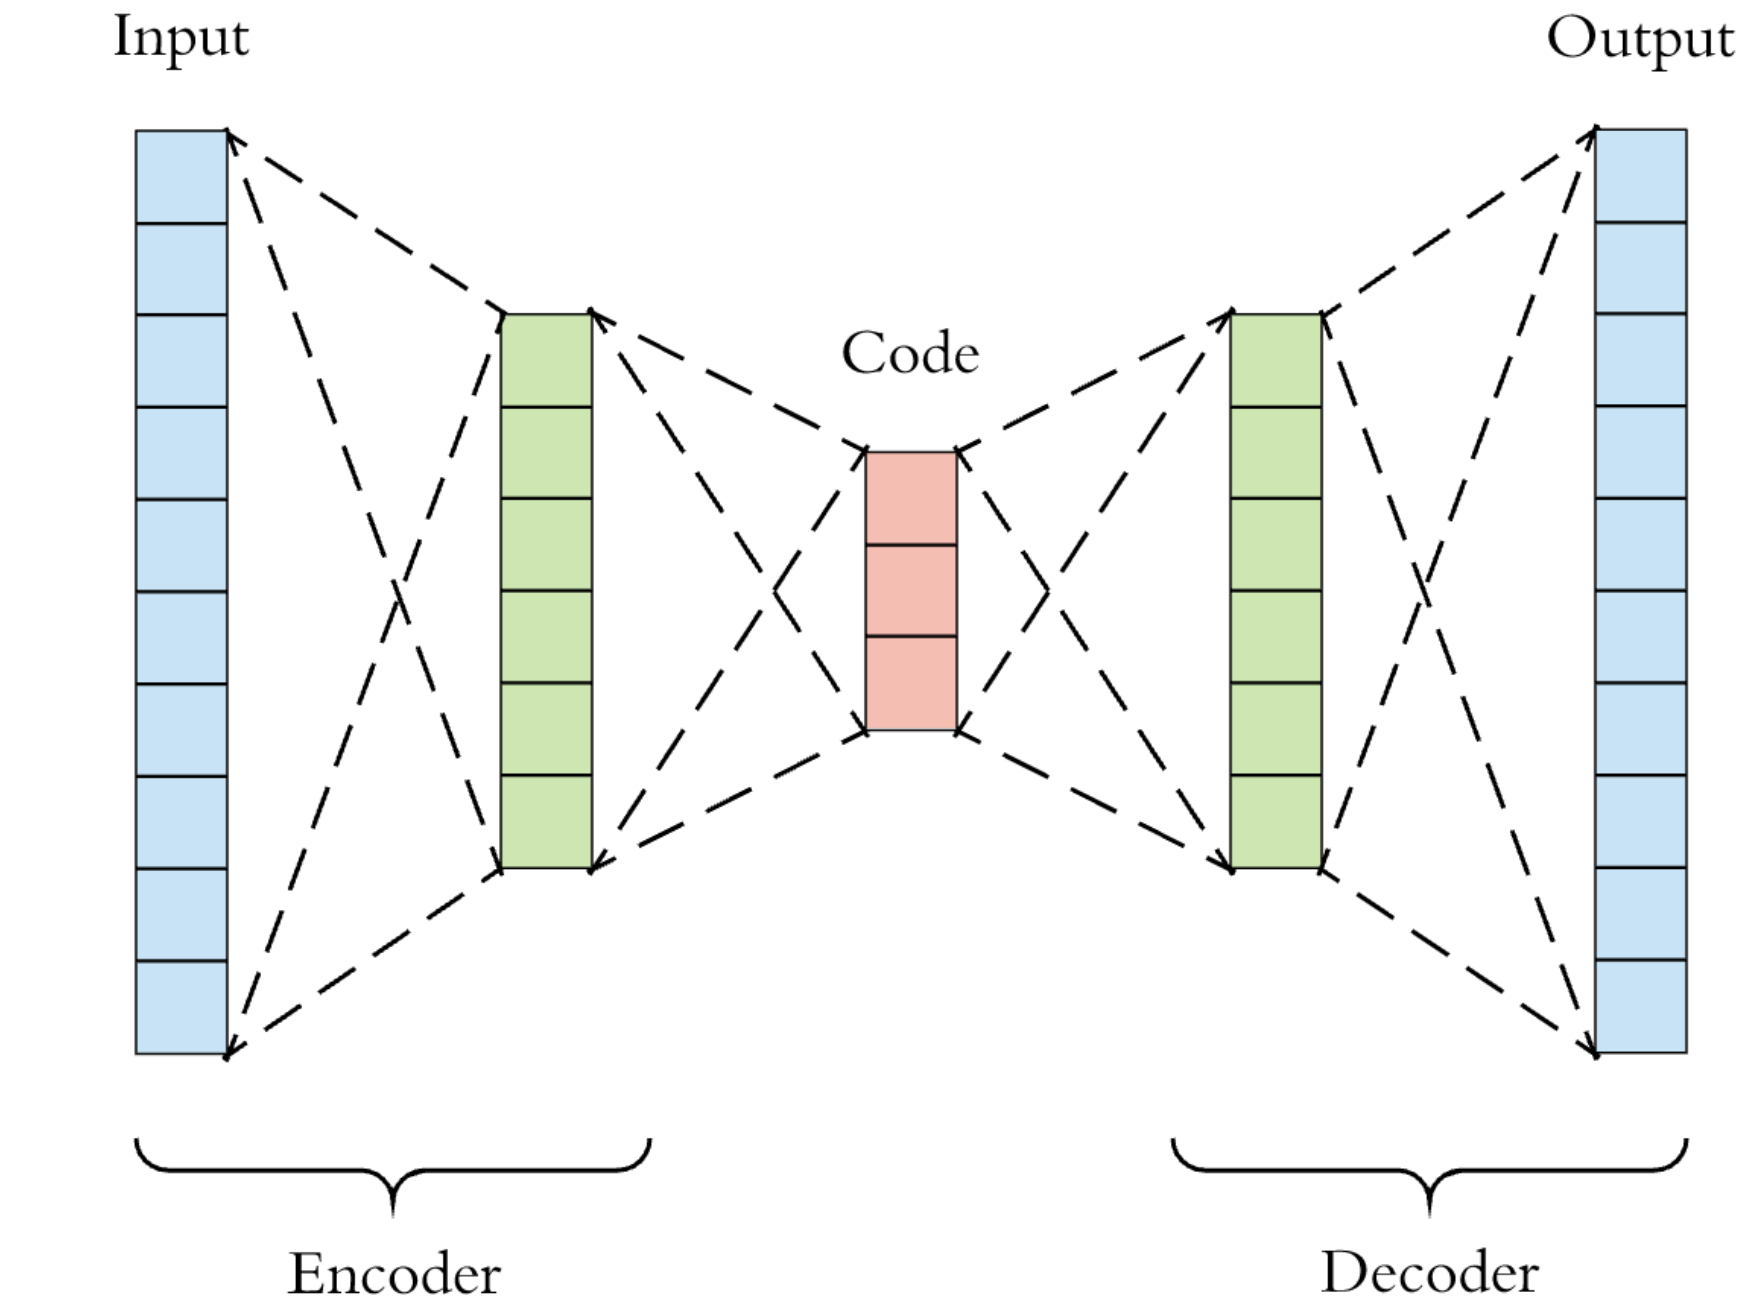

In [10]:
from IPython.display import Image

Image(filename = "/Users/cheikhtoure/Desktop/AutoEnco.png", width = 600, height = 300)

image source https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368

Un AutoEncodeur est un réseaux de neurones artificiels utilisés dans le cadre d'un Self-supervised learning pour apprendre des caractérisiques discriminantes. Pour plus de détails https://fr.wikipedia.org/wiki/Auto-encodeur#:~:text=Un%20auto%2Dencodeur%2C%20ou%20auto,non%20supervis%C3%A9%20de%20caract%C3%A9ristiques%20discriminantes.&text=R%C3%A9cemment%2C%20le%20concept%20d'auto,l'apprentissage%20de%20mod%C3%A8les%20g%C3%A9n%C3%A9ratifs.


L'AutoEncodeur que j'utilise est représenté dans la figure ci-dessus. Il est essentiellement composé d'un:
* Encodeur: il encode nos entrées dans un espace latent réduit où il apprend les représentations les plus importantes (on peut penser à un ACP dans une réduction de dimensionalité).
* Décodeur: il va essayer de reconstruire les données avec comme entrée, la sortie de l'encodeur qu'on note par ***z= Code***.

J'utilise des couches de convolution 1D (1 dimension) qui sont très performantes pour les données séquentielles. Vous pouvez consulter https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/.

La fonction coût considérée ici est le MSE (Mean Squared Error).

$$MSE=\frac{1}{n}\sum_{i=1}^{n}(Y_i-\hat Y_i)^2$$ où $Y_i$ représente la vraie valeur et $\hat Y_i$ la prédiction de l'individu i.

In [11]:
class Ae(nn.Module):
    '''
    Convolutional AutoEncoder:
    input:
    -----
    x: (B,Cin,l) where B is the batch size, Cin (number of channels), (l length)
    
    parameters:
    -----------
    kernel_size=3
    
    return:
    ------
    y:(B,Cout,l) reconstruction of x
    
    '''

    def __init__(self):
        super(Ae,self).__init__()
        self.encoder=nn.Sequential(
            nn.Conv1d(in_channels=seq.shape[1],out_channels=32, kernel_size=3),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Conv1d(in_channels=32,out_channels=16,kernel_size=3),
            nn.ReLU(True)
                                )
        
        
        self.decoder=nn.Sequential(
            nn.ConvTranspose1d(in_channels=16,out_channels=16,kernel_size=3),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(in_channels=16,out_channels=32,kernel_size=3),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=32,out_channels=seq.shape[1],kernel_size=1)
                                )
        
        
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x

On pourrait tester une autre valeur pour le kernel size, j'ai choisi 3. Le kernel size
pour la dernière couche du décodeur est paramétré à 1 ce qui permet d'avoir la bonne dimension pour la sortie https://stats.stackexchange.com/questions/194142/what-does-1x1-convolution-mean-in-a-neural-network.

J'entraine cet autoencodeur à reconstruire les données ***small_noise***.

Ici nous n'avons pas de label pour les données, l'idée est de pouvoir reconstruire les données input $\approx$ output. 

#### Apprentissage

In [12]:
lr=0.001 #learning rate
epochs=10
train_loss=[]
history=[]


model=Ae().double()  
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr)

for epoch in range(epochs):
    for s in seq:
        s.resize_(1,1,s.shape[1]) #batch size, number of channels, length
        output=model(s)
        loss=criterion(output,s)
        train_loss.append(loss.item())
        
        
        optimizer.zero_grad() # on remet à zéro les gradients
        loss.backward() #Calcule le gradient
        optimizer.step() #mets à jour les poids et biais
        
        
        
    history.append(np.mean(train_loss))    
        
        
        
        
        

Dans la figure ci-dessous, je trace l'évolution de notre score ***mse*** mean squared error sur nos données d'apprentissage.

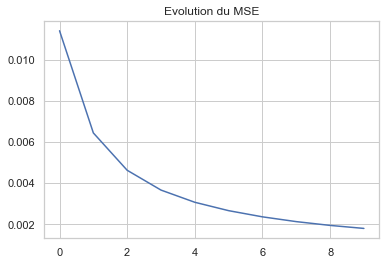

In [13]:
plt.plot(history);
plt.title('Evolution du MSE');

Notre modèle converge bien.

#### Enregistrement et Chargement de données Pytorch

Pour enregistrer ou charger notre modèle déjà entrainé.

In [14]:
path='model_state_dict.pt'

#Enregistrer notre modèle
torch.save(model.state_dict(), path)


In [15]:
#Pour charger le modèle enregistrer décommenter les lignes suivants
#model=Ae().double()
#model.load_state_dict(torch.load(path))
#model.eval()


#### Regardons comment notre modèle a reconstruit nos données d'apprentissage

In [16]:
#seq contient les séquences de valeur qu'on a utilisé pour l'entrainement

model=model.eval()
prediction_apprentissage=model(seq)

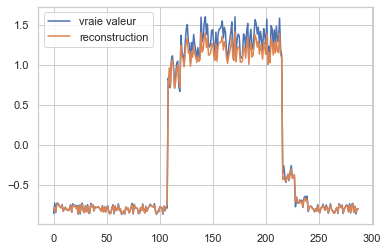

In [17]:
plt.plot(seq[0][0],label='vraie valeur');
plt.plot(prediction_apprentissage.detach()[0][0],label='reconstruction');
plt.legend();

J'ai essayé de visualiser dans la figure ci-dessus, la reconstruction de notre AutoEncodeur superposée aux vraies valeurs pour le premier jour.

Nous allons regarder à présent le MAE entre les prédictions sur les données d'apprentissage et les vraies valeurs. Mais avant, je vous explique la procèdure qui permet de séparer anomalie et non anomalie.

Soit A l'ensemble qui contient ces MAE, soit **maxA=max(A)**.
soit $x$ une nouvelle séquence et $xhat$ sa prédiction par le modèle.

Si $MAE=m(|x-xhat|)>maxA$, où m désigne la moyenne, 
on peut considérer que x est un outlier. Son MAE dépasse le max(MAE) pour toutes les séquences normales. Ainsi nous avons consruit un classifieur.

MAE: Mean Absolute Error

In [18]:
mae_apprentissage=np.mean(np.abs(seq.detach().numpy()-\
                                 prediction_apprentissage.detach().numpy()),axis=2)

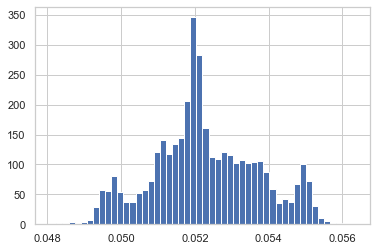

In [19]:
plt.hist(mae_apprentissage,bins=50);

In [20]:
#threshold=maxA
threshold=np.max(mae_apprentissage)

print('threshold: ',threshold)

threshold:  0.056338518986725344


le threshold correspond au maxA

### Prédiction sur les données test et visualisation des points prédits comme anomalie

La fonction qui suit permet de faire une prédiction sur un ensemble de séquences;

In [21]:

def predict(model,value):
    '''
    input:
    -----
    value: set of sequences
    model
    
    returns:
    -------
    prediction: numpy array
    
    '''
    model=model.eval()
    with torch.no_grad():
        pred=model(value)
    return pred
       

La fonction qui suit calcule le MAE.

In [22]:
#calcul du MAE (mean absolute error)
def mae(val,pred):
    return np.mean(np.abs(val.detach().numpy()-pred.detach().numpy()),axis=2).flatten()

La fonction ci-dessus permet de récupérer les indices dans le dataframe, des données classées comme anomalie. 

On considère qu'une donnée est une anomalie, si toutes les séquences où elle est présente, sont considérées comme des anomalies.

In [33]:
def data_indices(anomalies,df,length_Seq=288):
    '''
    Cette fonction retourne l'indice(implicite) des anomalies dans le dataframe
    '''
    
    ix_seq=create_S(np.array(range(df.shape[0]))) #crée les séquences pour les indices
    
    data=pd.DataFrame({'ix':ix_seq[anomalies].flatten()}) #mets tous les indices dans un dataframe
    a=data.value_counts()==length_Seq  #prends les indices qui sont présents 288 fois
    ix=a[a.values==True].index #On récupère ces indices
    ix=np.sort([int(i[0]) for i in ix])
    

    return ix

    

##  Test de notre modèle + détection anomalie sur art_daily_jumpsdown.csv

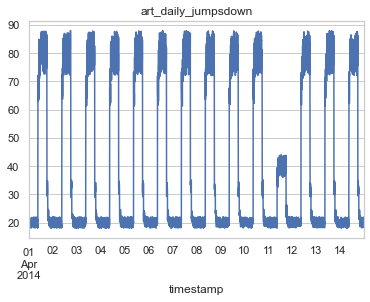

In [34]:
df_jumpdown=get_data(url='art_daily_jumpsdown.csv')
df_jumpdown_value=torch.tensor(create_S(normalize(df_jumpdown)))

In [35]:
prediction_art_daily_jumpdown=predict(model,df_jumpdown_value)

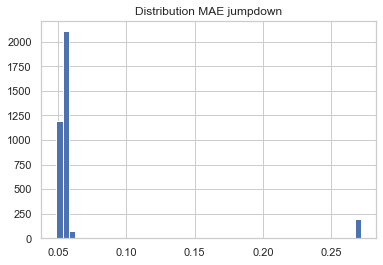

In [36]:
mae_jumpdown=mae(prediction_art_daily_jumpdown,df_jumpdown_value)
plt.hist(mae_jumpdown,bins=50);
plt.title('Distribution MAE jumpdown');

Dans la distribution ci-dessus, on peut distinguer deux groupes

Je compare donc les MAE avec le threshold définit avant. 

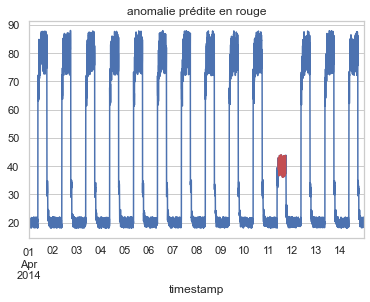

In [37]:
anomalies_jumpdown=np.where(mae_jumpdown>threshold) #comparaison mae et threshold

indices_anomalies_jumpdown=data_indices(anomalies_jumpdown,df_jumpdown) #récupère les indices


fig, ax = plt.subplots()
df_jumpdown.plot(legend=False, ax=ax)
df_jumpdown.iloc[indices_anomalies_jumpdown].plot(legend=False, ax=ax, color="r")
plt.title('anomalie prédite en rouge')
plt.show()

##  Test de notre modèle + détection anomalie sur art_daily_jumpsup.csv

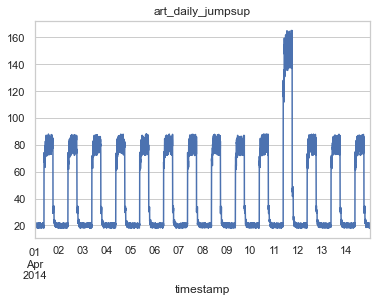

In [28]:
df_jumpup=get_data(url='art_daily_jumpsup.csv')
df_jumpup_value=torch.tensor(create_S(normalize(df_jumpup)))

In [29]:
prediction_art_dailyjumpup=predict(model,df_jumpup_value)

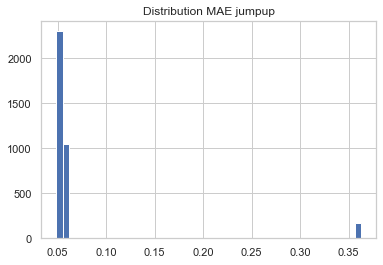

In [30]:
mae_jumpup=mae(df_jumpup_value,prediction_art_dailyjumpup)
plt.hist(mae_jumpup,bins=50);
plt.title('Distribution MAE jumpup');

On peut observer deux groupes dans les valeurs du MAE

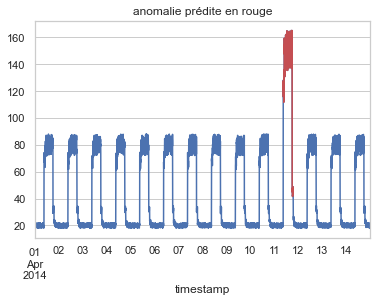

In [38]:
anomalies_jumpup=mae_jumpup>threshold

indices_anomalies_jumpup=data_indices(anomalies_jumpup,df_jumpup)





fig, ax = plt.subplots()
df_jumpup.plot(legend=False, ax=ax)
df_jumpup.iloc[indices_anomalies_jumpup].plot(legend=False, ax=ax, color="r",label=('anomalie'));
plt.title('anomalie prédite en rouge')
plt.show()

### Conclusion

Le Convolutional AutoEncodeur semble bien marcher sur cet exemple, il a détecté les deux anomalies sur les exemples test. Comme perspective nous pouvons:
* Entrainer cet AutoEncodeur sur d'autres données séquentielles, avec plus de  channels ou features
* Regarder différentes valeurs du batch size (avec plus de ressources), et du kernel size
* Tester un AutoEncodeur avec des réseaux récurrents (LSTM en particulier)
* Regarder d'autres statistiques pour le threshold


##### Sources:
https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368
https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose1d.html
https://stackoverflow.com/
https://pytorch.org/tutorials/beginner/saving_loading_models.html

Cheikh TOURE